from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="RAW CODE TOGGLE:Click here to toggle on/off the raw code."></form>''')

# Max Cohen - Ultimate Frisbee Statistics
(I've included the "raw code toggle" above in order to focus the notebook on the story of the visualizations. If you'd like to see the source code, just toggele the button!)

In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from pdb import set_trace
import glob
from collections import Counter
from IPython.display import HTML
from faker import Faker
from sklearn.linear_model import LinearRegression

### Read in data from pre-cleaned CSV files
(These were pre-cleaned in order to create fake player names)

In [262]:
player_stats_df = pd.read_csv('player_stats.csv',index_col=0)

In [263]:
full_poss_df = pd.read_csv('full_possessions.csv',index_col=0)

### Ultimate Frisbee and NYC Blueprint: Introduction
Before Coronavirus, I spent a lot of my time playing and coaching Ultimate Frisbee in NYC. I picked up the sport in undergrad and I've loved playing it ever since! Ultimate is a 7v7 game that combines the running of soccer, jumping of basketball, and the throwing and catching of Football. The offense tries to score a point by throwing the disc between teammates, scoring by catching the disc in the endzone. It's played on a field roughly the same size as an American Football field, just a little narrower.<br><br>
For the past few years (not this year unfortunately), I've played on an adult team called NYC Blueprint. We play competeitvely against other teams in our region and across the United States. Last summer (2019) we filmed some of our games and used that film to retroactively take stats using an app that tracks thrower and receiver locations amongst other things. I'm excited to show you and my team what I've learned from the data!

*Note: the names in this notebook have been replace with fake names*

### Seaborn Data Visualization Library
In order to demonstrate some key principles of Ultimate Frisbee and to learn more about our team, I'm going to be use **seaborn**. Seaborn is a data visualizatin library for Python. Much like some other Python visualiztion libraries, seaborn is built on top of matplotlib, which I'm quite comfortable with and allows for thorough plotting and customization options.<br><br>
Seaborn improves upon matplotlib's visual asthetics and makes it easier to encode variables in multiple ways in one plot. Additionally, there are a couple unique and new visualization techniques in seaborn. Namely, built-in functionality for **lineplot confidence intervals** and **jointplots** which combine multiple types of visualization techniques in one figure.

### An Example Ultimate Frisbee Point
Before we go any further, this is an example frisbee point. As I said before, ultimate is played with 7 people on each team on the field at the same time. However, ONLY the thrower and receiver are represented in our data. The defense and other players on the field are not present. <br><br>
The disc starts at the bottom of the plot, roughly on the endzone line of the "defending endzone". Blueprint has possession and is trying to score in the "scoring endzone", roughly 70 meters away. The disc zigs and zags up the field as it is passed between players until Mark throws a beautiful long pass (a "huck") to Nicholas in the scoring endzone for a goal! <br><br>
The colors represent the two main position distinctions in Ultimate. Blue for "cutters" -- they are like receivers in American Football, often gaining distance more by catching the disc than by throwing it. Orange for "handlers" -- the quaterbacks of Ultimate, often taking the more difficult and longer throws. Lastly, sometimes the disc is thrown backwards, but not to worry, that's okay. It's sometimes better to throw it backwards than to make a mistake and throw the disc out of bounds or to the other team, giving them a chance to score. Thrower or receiver mistakes, more generally known as turnovers, are really bad in ultimate!

### Probability of Scoring Based on Distance from Endzone
Below, I've plotted our probability of scoring by our vertical position on the field. As we get closer to the scoring endzone, our chances of scoring before we make a mistake (turnover) go up.

In [264]:
#create bins every two yards
bin_list = []
yardage = 3
for x in range(-3,109,yardage):
    bin_list.append(x + yardage)
    
bins = np.array(bin_list)
#change bins to 0->1 range
bins = [x/110 for x in bins]
#create columns
full_poss_df['y_bucket'] = (pd.cut
                            (full_poss_df['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)'],
                              bins))
#create hist of all plays
all_hist = np.histogram(1-full_poss_df['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)'],bins)
#create hist of scored plays
scored_df = full_poss_df[full_poss_df['Scored?'] == 1]
scored_hist = np.histogram(1-scored_df['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)'],bins)

#get bins
all_y = all_hist[0]
scored_y = scored_hist[0]
bins_data = bins[:-1]
#create dict
d = {'all_y':all_y, 'scored_y':scored_y, 'bins':bins_data}
y_score_df = pd.DataFrame(data = d)

#col for conversion rate
y_score_df['conversion_rate'] = y_score_df['scored_y'] / y_score_df['all_y']
#col for yards
y_score_df['yards'] = y_score_df.index * yardage

#remove NAs
y_score_df = y_score_df.dropna()
#create all df so that we can use for expected points added later
y_score_df_all = y_score_df
#final filter to only include number of possessions > 10
y_score_df = y_score_df[y_score_df['all_y'] > 10]

In [265]:
#fit least squares line to FULL x and y data
x = y_score_df_all['yards']
y = y_score_df_all['conversion_rate']
z = np.polyfit(x,y,1)
p = np.poly1d(z)
for i in range(0,100,10):
    print(p(i))

0.2665620393962794
0.32478408840764555
0.3830061374190116
0.44122818643037776
0.49945023544174383
0.5576722844531099
0.6158943334644761
0.6741163824758422
0.7323384314872083
0.7905604804985744


In [266]:
#the same analysis on horizontal EP for horizontal field positioning 
#led to a line with slope (0.000448259839) and intercept (0.53346877)
#meaning that probability of scoring was almost entirely irrelevant of horizontal field position
#surprising!
#as such, we will not include it in our analysis

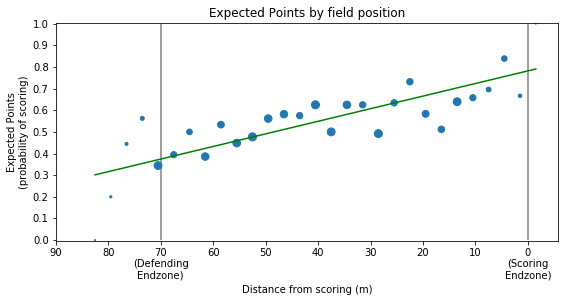

In [267]:
#by vertical position on the field
#probability of scoring by field position
fig = plt.figure(figsize=(9,4))

x = y_score_df_all['yards']+(.5*yardage)#<-center the point in the middle of the bin
y = y_score_df_all['conversion_rate']
s = y_score_df_all['all_y']
plt.scatter(x,y,s=s)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"g",zorder=1)

plt.vlines([20,90],ymin=0,ymax=1,alpha=.5,zorder=0)
plt.margins(y=0)

xtick = 10
ytick = .1

plt.xticks(ticks=[xtick*9,xtick*8,xtick*7,xtick*6,xtick*5,xtick*4,xtick*3,xtick*2,xtick*1,xtick*0],
          labels=[90,80,'70\n(Defending\nEndzone)',60,50,40,30,20,10,'0\n(Scoring\nEndzone)'][::-1])
plt.yticks(ticks=[ytick*0,ytick,ytick*2,ytick*3,ytick*4,ytick*5,ytick*6,ytick*7,ytick*8,ytick*9,ytick*10])
plt.xlabel('Distance from scoring (m)')
plt.ylabel('Expected Points\n(probability of scoring)')
plt.title('Expected Points by field position')

#plt.grid(which='major', axis='y' ,linestyle='-.', linewidth='.2', color='black')
plt.show()

### Expected Points Added
Using the probability of scoring line above, I borrowed an advanced metric from American Football called Expected Points Added (EPA). For Ultimate, EPA takes your current position on the field and returns the Expected Points (ex: 30 meters from scoring, our EP is ~.6 points). Each throw adds or gains yards so each throw has an Expected Points ADDED.
**For scoring throws**, the Expected Points at the end of the throw is 1 because a goal is worrth 1 point in Ultimate. So, for scoring throws (assists), EPA = 1-EP.
**For throwing errors**, we subtract the Expected Points at the beginnig of the throw and subtract that value. So, for throwing errors, EPA = -EP. 
*Note: there are some variables curently missing in EPA, like expected completion percentage, the quality of the receiver, the "value" of a turnover depending on where the turnover occurs, etc... I'll work on these later* <br><br>
Let's go back to our example point and see the EPA for that beautiful assist from Mark to Nicholas.

In [351]:
#CREATE epa_y
#**this is ONLY in the y direction**
# --- doesn't take into acount assists, receiver epa, turnovers, turnover probability
#take the line function from the above graph
#apply it to each value in forward distance
# --- this alone would give us the epa of the position on the field that equates to that throw distance
#so in order to get the epa that the throw added, we need to subtract the epa we already had at the start of throw
# --- however, we take inverse to get the correct value
start = (110-full_poss_df['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)']*110)
full_poss_df['epa_y'] = ( p(full_poss_df['Forward distance (m)']+start) - p(start) )

#to find full epa
# --- make assists == 1 - EP at start of throw
# --- make throwing errors == -EP at start of throw
# --- --- but are some turnovers better than others?
# --- --- can we weight completion percentage? ie if a throw is lower completion per, it should have negative val

#find the opponents yards to go (ytg) for a score
full_poss_df['opp_ytg'] = (((1-
                            full_poss_df['End Y (0 -> 1 = back of opponent endzone -> back of own endzone)'])
                           *110)-20)
#adjust ytg so that it is only a 70 yard distance
#no values larger than 70 - when we turn it in the scoring endzone, they bring it to goal line (70 away)
#no values smaller than 0 - when we turn it in our defending endzone, they bring it to goal line (0 away)
full_poss_df['opp_ytg'] = (full_poss_df['opp_ytg']
                           .apply(lambda x: 70 if x>70 else x)
                           .apply(lambda x: 0 if x<0 else x))
#apply the probability of scoring line
#90 minus because 90 is the goal line for the offense in the original fit
#example if the opponent is 10 yds from scoring, we need to get p @ 80 (10 yards from scoring in original math)
full_poss_df['opp_epa_yat'] = p(90-full_poss_df['opp_ytg'])


def epa_throw_type(row):
    if row['Assist?'] == 1:
        return 1 - p(110-row['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)']*110)
    elif row['Thrower error?'] == 1:
        #this is just negative version of the y_position on field
        #claims that we would go to 0 probability of scoring
        raw = -p(110-row['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)']*110)
        #to adjust this, we just use reverse the prob of scoring model and give it to opponent
        #in order to weight the turnover, we multiply the raw value by adjusted value
        #this will penalize the thrower LESS b/c it says that the chance of scoring does not go all the way to 0
        adj = row['opp_epa_yat']
        return raw * adj
    else:
        return row['epa_y']
        
full_poss_df['epa_yat'] = full_poss_df.apply(epa_throw_type,axis=1)

### Account for quality of turnovers in EPA
When we turn it over, how likely are we to still score?
We can use our own data as a proxy for how likely the other team is to score!
- Across our games we scored 1.17 more points than the other teams
- So for this data, we can assume that the other team will score .8558 as often as we did from each position

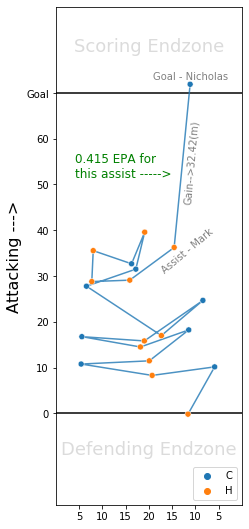

In [361]:
#epa for each throw in a point
#Longest successful point
fig, ax = plt.subplots(figsize=(4/1.2,11/1.2))

df = full_poss_df.copy()
df = df[ (df['Passes'] == df['Passes'].max()) & (df['Point'] == 18)]

x = (df['Start X (0 -> 1 = left sideline -> right sideline)'].append( 
       pd.Series(df['End X (0 -> 1 = left sideline -> right sideline)'].iloc[-1])))
y = 1 - (df['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)'].append( 
     pd.Series(df['End Y (0 -> 1 = back of opponent endzone -> back of own endzone)'].iloc[-1])))
hue = df['Thrower_position'].append(pd.Series(df['Receiver_position'].iloc[-1]))

grid = sns.lineplot(x=x,y=y,alpha=.8,sort=False,ax=ax,zorder=1)
sns.scatterplot(x=x,y=y,alpha=1,hue=hue,hue_order=['C','H'],zorder=2)

#make field
c = 'k'
grid.axvline(x=0,color=c,alpha=0)
grid.axvline(x=1,color=c,alpha=0)
grid.axhline(y=0,color=c,alpha=0)
grid.axhline(y=.1818181818,color=c,zorder=0)
grid.axhline(y=.8181818181,color=c,zorder=0)
grid.axhline(y=.99,color=c,alpha=0)
grid.margins(x=0,y=0)

#set x and yticks as yard markers every 10 yards
xtick = .25/2
ytick = .181818/2
grid.set_xticks([xtick,xtick*2,xtick*3,xtick*4,xtick*5,xtick*6,xtick*7])
grid.set_xticklabels([5,10,15,20,15,10,5])
grid.set_yticks([ytick*2,ytick*3,ytick*4,ytick*5,ytick*6,ytick*7,ytick*8,ytick*9])
grid.set_yticklabels([0,10,20,30,40,50,60,'Goal'])

grid.set_xlabel('')
grid.set_ylabel('Attacking --->',fontsize=16)

#annotate endzones
grid.text(.50,.9,'Scoring Endzone',
          ha='center',color='lightgray',alpha=.8,fontsize=18)
grid.text(.50,.1,'Defending Endzone',
          ha='center',color='lightgray',alpha=.8,fontsize=18)


#annotate names
goal = df.iloc[-1]
#goal
grid.text(goal['End X (0 -> 1 = left sideline -> right sideline)'],
          (1-goal['End Y (0 -> 1 = back of opponent endzone -> back of own endzone)']) + .01,
          'Goal - {}'.format(df.iloc[-1]['Receiver'].split(' ')[0]),
          ha='center',color='gray')
#assist
grid.text(goal['Start X (0 -> 1 = left sideline -> right sideline)']+.07,
          (1-goal['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)']) - .05,
          'Assist - {}'.format(df.iloc[-1]['Thrower'].split(' ')[0]),
          ha='center',rotation=40,color='gray')
#length
grid.text(.73,.6,
          'Gain-->{}(m)'.format(df.iloc[-1]['Forward distance (m)'].round(2)),
          ha='center',rotation=85,color='gray')

grid.text(.1,.65,
          '{} EPA for\nthis assist ----->'.format(round(goal['epa_yat'],3)),
            ha='left',color='green',size='large')

ax.legend(loc='lower right')
plt.show()

Below, I've included a quadrant plot of all the players on the team. The y axis shows the sum of EPA and the x axis charts the mean. The color of the point shows the position of the player (Cutter, Handler). The size of the point shows the total number of throws for that player.<br><br>
You can see that BC stands out from the team, accumulating >4 total EPA on .05 EPA per throw. Anecdotaly, most players on the team would say that BC was our Most Valuable Player, so EPA is doing well so far!<br><br>
**Seaborn** makes it easy to encode variables in multiple ways. The seaborn scatterplot function allowed me to encode position (x,y), hue, and size in one line. The legend plots automatically, without even referring to it in the code. Lastly, the dashed lines on this chart represent the means to the x and y axis, splitting the plot into quadratns with the upper right quadrant generally being "better".

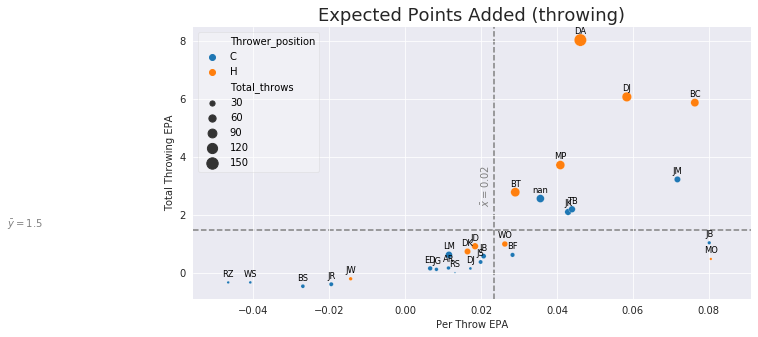

In [362]:
#groupings of handlers and cutters by average catches
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(10,5))
sns.despine(fig,left=True,bottom=True)

df = full_poss_df.groupby(['Thrower','Thrower_position'])['epa_yat'].agg(['mean','sum','size']).reset_index()
df = (df.merge(player_stats_df[['Player','player_inits']],
               left_on='Thrower',right_on='Player',how='left'))
df.rename(columns={'size':'Total_throws'},inplace=True)

x = 'Thrower'
y1 = 'mean'
y2 = 'sum'


pl = sns.scatterplot(data=df,x=y1,y=y2,hue='Thrower_position',hue_order=['C','H'],size='Total_throws',sizes=(2,150))

plt.axvline(df[y1].mean(),color='gray',linestyle='dashed',zorder=0)
plt.axhline(df[y2].mean(),color='gray',linestyle='dashed',zorder=0)

# ann = (df[ (df[y2] > df[y2].mean()) | (df[y1] > df[y1].mean())]
#        .reset_index(drop=True))
ann = df
for i in range(0,ann.shape[0]):
    pl.text(ann[y1][i],ann[y2][i]+.2,ann['player_inits'][i],ha='center',size='small')

#annotate dashed lines
pl.text(df[y1].mean()-.002,3,f'$\\bar x = {round(df[y1].mean(),2)}$',
        rotation=90,ha='center',va='center',color='gray')
pl.text(-.1,df[y2].mean()+.18,f'$\\bar y = {round(df[y2].mean(),2)}$',
        rotation=0,ha='center',va='center',color='gray')

ax.set_ylabel('Total Throwing EPA')
ax.set_xlabel('Per Throw EPA')

ax.legend(framealpha=.3)
plt.title('Expected Points Added (throwing)',fontsize=18)
plt.show()

In [129]:
tot_poss = len(full_poss_df.groupby(['possession_index'])['Possession'].first().reset_index()['Possession'])
tot_scores = full_poss_df['Assist?'].sum()
base_score_rate = tot_scores / tot_poss
#scored on .4883 of all possessions
#this is base scoring rate
#so when a point starts, we have this chance of scoring and it changes by field position

0.48826291079812206

In [ ]:
#The analysis below essentially DOES NOT work.

In [204]:
#can we find the other team's chances of scoring by field position where we turn it over?

#get all possessions that end in a turnover, but do not end in a point loss
#could do separate groupbys
#merge on a groupby of point index where we do not score
end_turn = ( full_poss_df.groupby(['possession_index'])
 [['opponent','Point','Scored?','Turnover?','End Y (0 -> 1 = back of opponent endzone -> back of own endzone)']]
 .last().reset_index() )
#possesions that end in a turnover
end_turn = end_turn[end_turn['Turnover?'] == 1]
#points that end in a score for us
end_score = full_poss_df.groupby(['opponent','Point'])['Scored?'].last().reset_index()
end_score = end_score[end_score['Scored?'] == 1]
#these are all the possessions where we turn it, BUT got the disc back
#y values of our last turnover are included
got_disc_back = pd.merge(end_turn,end_score,on=['opponent','Point'],how='inner')

#get all possessions that end in a turnover AND end in a point loss
end_loss = full_poss_df.groupby(['opponent','Point'])['Scored?'].last().reset_index()
end_loss = end_loss[end_loss['Scored?'] == 0]
#turned it then lost the point
no_disc_back = pd.merge(end_turn,end_loss,on=['opponent','Point'],how='inner')


#lump all throws into endzone into same bucket
got_disc_back['End Y (0 -> 1 = back of opponent endzone -> back of own endzone)'] = (
    got_disc_back['End Y (0 -> 1 = back of opponent endzone -> back of own endzone)']
    .apply(lambda x: .19 if x  < .181818 else x))
no_disc_back['End Y (0 -> 1 = back of opponent endzone -> back of own endzone)'] = (
    no_disc_back['End Y (0 -> 1 = back of opponent endzone -> back of own endzone)']
    .apply(lambda x: .19 if x  < .181818 else x))

In [207]:
#create histograms for each
#remember to take inverse of y values
#note that they are heavily skewed towards throws that go into the endzone. this is anecdotaly correct
got_disc_back_hist = ( np.histogram(
    1-got_disc_back['End Y (0 -> 1 = back of opponent endzone -> back of own endzone)'],bins) )
no_disc_back_hist = ( np.histogram(
    1-no_disc_back['End Y (0 -> 1 = back of opponent endzone -> back of own endzone)'],bins) )

In [222]:
#get bins
yes = got_disc_back_hist[0]
no = no_disc_back_hist[0]
bins_data = bins[:-1]
#create dict
d = {'got_disc_back':yes, 'no_disc_back':no, 'bins':bins_data}
y_turn_df = pd.DataFrame(data = d)

#col for conversion rate
y_turn_df['scored_rate'] = y_turn_df['got_disc_back'] / (y_turn_df['got_disc_back'] + 
                                                           y_turn_df['no_disc_back'])
#col for yards
y_turn_df['yards'] = y_turn_df.index * yardage

y_turn_df.dropna(inplace=True)

#fit to line
x = y_turn_df['yards']
y = y_turn_df['scored_rate']
z = np.polyfit(x,y,7)
p = np.poly1d(z)
plt.plot(x,p(x))
plt.scatter(x,y)

#WELLLLLLL
#TURNS OUT THERE ISN'T ENOUGH DATA HERE
#CAN'T FIGURE OUT OTHER TEAMS CHANCES OF SCORING BASED ON WHERE WE TURN THE DISC OVER